In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import itertools
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

# Exercise 1

In [31]:
def getDistances(A):

  if type(A) is not np.ndarray:
    A = A.to_numpy()

  n = A.shape[0]
  D = np.zeros((n, n))
  for i in range(n):
    for j in range(i + 1, n):
      D[i][j] = np.linalg.norm(A[i] - A[j])
      D[j][i] = D[i][j]
  return D

In [3]:
def getW(D, U, V):
    total_weight = 0.0
    
    for u in U:
        for v in V:
            total_weight += D[u][v]
    
    return total_weight

In [50]:
def getWIn(D, C):
    win = 0.0

    cluters_set = list(set(C))
    for cluster in cluters_set:
        indices = np.where(np.array(C) == cluster)[0]
        win += getW(D, indices.tolist(), indices.tolist())
    return (win/2).round()

def getWOut(D, C):
    wout = 0.0
    for cluster in set(C):
        cluster_indices = np.where(np.array(C) == cluster)[0]
        other_indices = np.where(np.array(C) != cluster)[0]
        wout += getW(D, cluster_indices.tolist(), other_indices.tolist())
    return (wout/2).round()

In [5]:
def getNIn(C):
    nin = 0
    for cluster in set(C):
        cluster_indices = np.where(np.array(C) == cluster)[0]
        nin += len(cluster_indices) * (len(cluster_indices) - 1) // 2
    return nin

def getNOut(C):
    n = len(C)
    nout = n * (n - 1) // 2 - getNIn(C)
    return nout

In [34]:
def getBetaCV(A, C):
    D = getDistances(A=A)
    w_in = getWIn(D=D,C=C)
    n_in = getNIn(C=C)
    w_out = getWOut(D=D,C=C)
    n_out = getNOut(C=C)

    return (w_in / n_in)/(w_out / n_out)    

In [63]:
def getCIndex(A, C):
    D = getDistances(A=A)
    w_in = getWIn(D=D,C=C)
    n_in = getNIn(C=C)

    w_sorted = np.sort((np.tril(D)).flatten())

    first_index = 0
    while w_sorted[first_index] == 0:
        first_index += 1
        
    w_min = sum(w_sorted[:(n_in + first_index)])
    w_max = sum(w_sorted[len(w_sorted) - n_in:])

    return (w_in - w_min)/(w_max - w_min)

In [145]:
def getNormalizedCut(A, C):
    nc_list = 0

    D = getDistances(A=A)

    index_set = list(set(C))
    index_lists = []

    for index in index_set:
        index_list = []
        for i, label in enumerate(C):
            if label == index:
                index_list.append(i)

        index_lists.append(index_list)

    for i, index_i in enumerate(index_set):
        w_ci_else = 0
        vol_ci = 0
        for j, index_j in enumerate(index_set):
            w = getW(D=D, U=index_lists[i], V=index_lists[j])
            if index_i != index_j:
                w_ci_else += w
                vol_ci += w
            else:
                vol_ci += w

        nc_list += w_ci_else / vol_ci

    return nc_list

In [103]:
def getDunn(A, C):
    D = getDistances(A=A)

    mask = np.zeros_like(D)

    n = len(C)

    for i in range(n):
        mask[i][i] = True
        for j in range(i + 1, n):
            if C[i] == C[j]:
                mask[i][j] = True
                mask[j][i] = True
            else:
                mask[i][j] = False
                mask[j][i] = False

    w_in = np.where(mask,D,-1)
    w_max_in = w_in.max()

    w_out = np.where(np.logical_not(mask), D, np.inf)
    w_out = np.sort(w_out.flatten())

    w_min_out = 0
    i = 0
    while w_min_out == 0:
        w_min_out = w_out[i]

    return w_min_out / w_max_in

In [100]:
def getDaviesBouldin(A, C):
    if type(A) is not np.ndarray:
        A = A.to_numpy()

    db_list = []

    indexes = list(set(C))
    k = len(indexes)

    cluster_lens = [0] * k
    cluster_means = []
    cluster_dispersion = []

    for index in C:
        cluster_lens[indexes.index(index)] += 1

    for i, index in enumerate(indexes):
        data_in_c = []
        for j, point_index in enumerate(C):
            if point_index == index:
                data_in_c.append(A[j])

        mean = sum(data_in_c) / cluster_lens[i]
        cluster_means.append(mean)

        var = 0
        for data in data_in_c:
            var += (np.linalg.norm(data - mean)) ** 2
        var = var / cluster_lens[i]
        disp = var ** 0.5
        cluster_dispersion.append(disp)

    for i in range(k):
        temp = []
        for j in range(k):
            if i != j:
                db = (cluster_dispersion[i] + cluster_dispersion[j]) / np.linalg.norm(cluster_means[i] - cluster_means[j])
                temp.append(db)

        db_list.append(max(temp))

    return (1/k) * sum(db_list)

In [142]:
def getSilhouette(A, C):
    if type(A) is not np.ndarray:
        A = A.to_numpy()

    si_list = []

    indexes = list(set(C))
    index_lists = []

    #construye una lista que tiene en cada index j otra lista con los index de las variables en A que pertenecen a cada cluster j
    for index in indexes:
        index_list = []
        for i, label in enumerate(C):
            if label == index:
                index_list.append(i)

        index_lists.append(index_list)

    for i, cluster_name in enumerate(C):
        current_index = indexes.index(cluster_name)
        
        weights = []
        for j, index in enumerate(indexes):
            if index != cluster_name:
                weights.append((getW(D=getDistances(A=A), U=index_lists[current_index], V=index_lists[j]), index))

        closest_cluster = (np.inf, -1)
        for weight, clust_id in weights:
            if weight < closest_cluster[0]:
                closest_cluster = (weight,clust_id)

        mean_in = 0
        mean_min_out = 0
        in_len = 0
        min_out_len = 0

        for j in range(len(C)):
            if i != j: 
                if C[i] == C[j]:
                    mean_in += np.linalg.norm(A[i] - A[j])
                    in_len += 1
                elif C[j] == closest_cluster[1]:  
                        mean_min_out += np.linalg.norm(A[i] - A[j])
                        min_out_len += 1

        mean_in = mean_in/(in_len-1)
        mean_min_out = mean_min_out/min_out_len

        si = (mean_min_out - mean_in) / max([mean_min_out,mean_in])
        si_list.append(si)

    return (1/len(si_list)) * sum(si_list)

In [12]:
def getMetric(A, C, metric):
    if metric == "beta":
        return getBetaCV(A=A, C=C)
    elif metric == "cindex":
        return getCIndex(A=A, C=C)
    elif metric == "nc":
        return getNormalizedCut(A=A, C=C)
    elif metric == "dunn":
        return getDunn(A=A, C=C)
    elif metric == "db":
        return getDaviesBouldin(A=A, C=C)
    elif metric == "sil":
        return getSilhouette(A=A, C=C)

## Testing

In [54]:
# Test weights
import pandas as pd_test
import numpy as np_test
dfIrisTest = pd_test.read_csv("https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv")
A_Iris_Test = dfIrisTest[dfIrisTest.columns[:4]].astype(float)
C_Iris_Test = dfIrisTest[dfIrisTest.columns[4]]
D_Iris_Test = getDistances(A_Iris_Test)
C1 = np.where(C_Iris_Test == 'setosa')[0]
C2 = np.where(C_Iris_Test == 'versicolor')[0]
C3 = np.where(C_Iris_Test == 'virginica')[0]
CList = [C1, C2, C3]

print ("\nTest Weight Measures\n------------------")
expectedW = {
    (0,1): 8246,
    (0,2): 12056,
    (1,2): 4606
}
wSummary = "W: "
wFailed = False
for i in range(3):
    for j in range(i):
        p1 = (i,j)
        p2 = (j,i)
        W1 = np_test.round(getW(D_Iris_Test, CList[i], CList[j]))
        W2 = np_test.round(getW(D_Iris_Test, CList[j], CList[i]))
        if W1 != W2:
            if not wFailed:
                wSummary += "failed"
            wSummary += "\n\tasymmetry of W: " + str(W1) + " != " + str(W2)
            wFailed = True
        
        if W1 != expectedW[p2]:
            if not wFailed:
                wSummary += "failed"
            wSummary += "\n\tunexpected value of W: " + str(W1) + " instead of expected " + str(expectedW[p2])
            wFailed = True
if not wFailed:
    wSummary += "ok"
print(wSummary)
expectedWIn = 3518
expectedWOut = 24908
expectedNIn = 3675
expectedNOut = 7500
print("WIn:", "ok" if np_test.abs(np_test.round(getWIn(D_Iris_Test, C_Iris_Test)) - expectedWIn) < 2 else "failed")
print("WOut:", "ok" if np_test.abs(np_test.round(getWOut(D_Iris_Test, C_Iris_Test)) - expectedWOut) < 2 else "failed")
print("NIn:", "ok" if getNIn(C_Iris_Test) == 3675 else "failed")
print("NOut:", "ok" if getNOut(C_Iris_Test) == 7500 else "failed")


Test Weight Measures
------------------
W: ok
WIn: ok
WOut: ok
NIn: ok
NOut: ok


In [146]:
# Test weights
import pandas as pd_test
import numpy as np_test
dfIrisTest = pd_test.read_csv("https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv")
A_Iris_Test = dfIrisTest[dfIrisTest.columns[:4]].astype(float)
C_Iris_Test = dfIrisTest[dfIrisTest.columns[4]]
D_Iris_Test = getDistances(A_Iris_Test)

# Test metrics
print ("\nTest Metrics\n------------------")
expected = {
    "beta": 0.2882861014913346,
    "cindex": 0.046803774122703735,
    "nc": 2.6150343040385264,
    "dunn": 0.05848053214719304,
    "db": 0.8445815484442534,
    "sil": 0.5032506980665507
}
for m in expected:
    e = np.round(expected[m], 2)
    a = getMetric(A_Iris_Test, C_Iris_Test, m)
    a = np.round(a, 2) if not a is None else None
    print(m + ":\t", "ok" if e == a else "failed. Expected " + str(e) + " but saw " + str(a))


Test Metrics
------------------
beta:	 ok
cindex:	 ok
nc:	 ok
dunn:	 ok
db:	 ok
sil:	 ok


# Exercise 2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


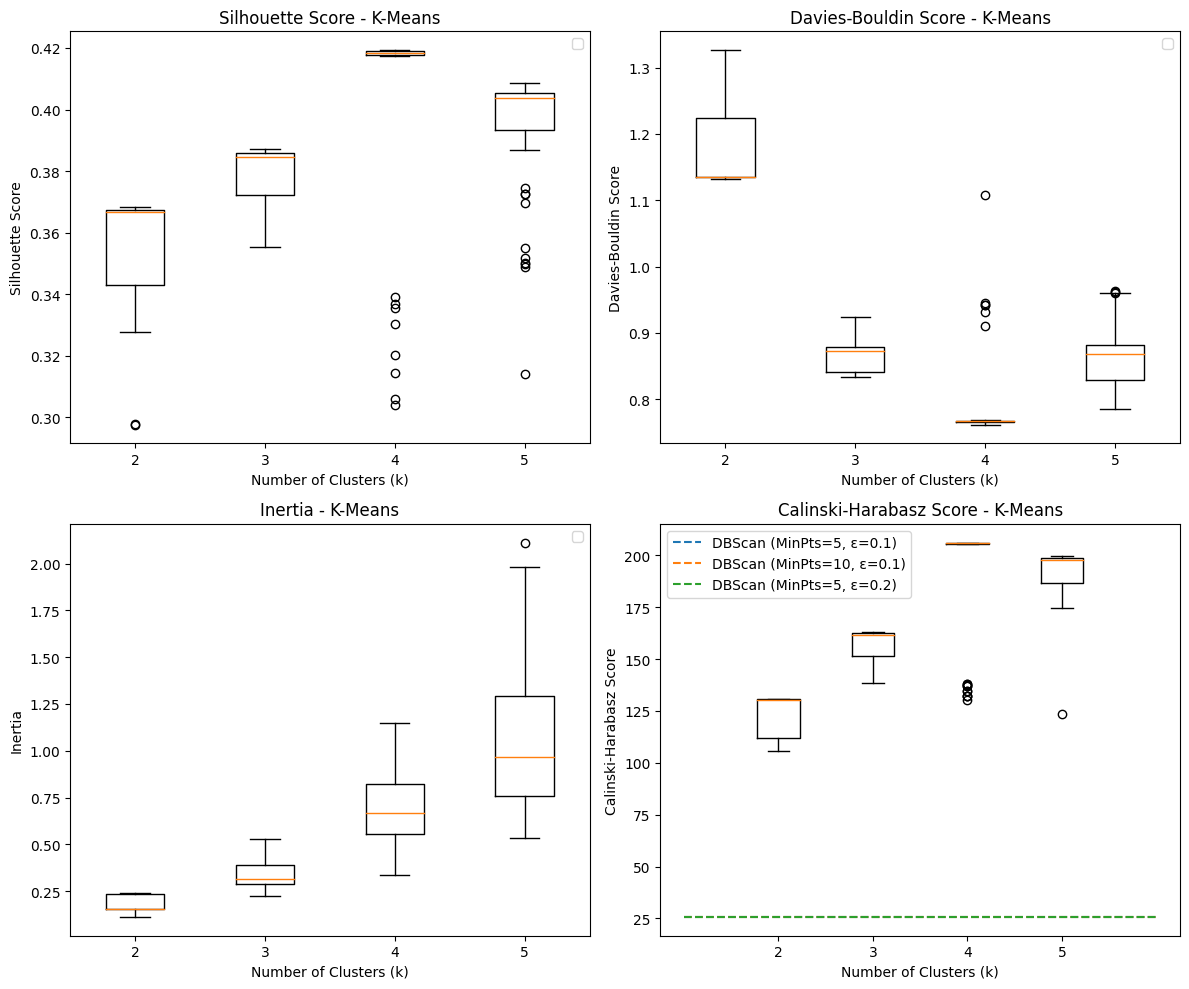

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

def plotMetrics(D, l=100, kmeans_eps=0.01, dbscan_configs=None):
    if isinstance(D, pd.DataFrame):
        D = D.values

    k_values = [2, 3, 4, 5]
    metrics_names = ["Silhouette Score", "Davies-Bouldin Score", "Inertia", "Calinski-Harabasz Score"]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.subplots_adjust(hspace=0.5)
    axes = axes.ravel()

    for metric_idx, metric_name in enumerate(metrics_names):
        kmeans_results = []
        dbscan_results = []

        for k in k_values:
            kmeans_scores = []
            for _ in range(l):
                mu, labels, inertia = kMeans(D, k, kmeans_eps)
                if metric_name == "Silhouette Score":
                    score = metrics.silhouette_score(D, labels)
                elif metric_name == "Davies-Bouldin Score":
                    score = metrics.davies_bouldin_score(D, labels)
                elif metric_name == "Calinski-Harabasz Score":
                    if len(np.unique(labels)) > 1:  # Verificar si hay al menos dos clusters
                        score = metrics.calinski_harabasz_score(D, labels)
                    else:
                        score = None
                else:
                    score = inertia
                kmeans_scores.append(score)
            kmeans_results.append(kmeans_scores)

            if metric_name != "Silhouette Score" and metric_name != "Davies-Bouldin Score":
                dbscan_scores = []
                for minpts, eps in dbscan_configs:
                    labels = DBSCAN(D, epsilon=eps, minpts=minpts)
                    if metric_name == "Calinski-Harabasz Score":
                        if len(np.unique(labels)) > 1:  # Verificar si hay al menos dos clusters
                            score = metrics.calinski_harabasz_score(D, labels)
                        else:
                            score = None
                    elif metric_name == "Davies-Bouldin Score":
                        mask = labels != -1
                        score = metrics.davies_bouldin_score(D[mask], labels[mask])
                    else:
                        score = None
                    if score is not None:
                        dbscan_scores.append(score)
                dbscan_results.append(dbscan_scores)

        ax = axes[metric_idx]
        ax.boxplot(kmeans_results, labels=k_values)
        ax.set_title(f"{metric_name} - K-Means")
        ax.set_xlabel("Number of Clusters (k)")
        ax.set_ylabel(metric_name)

        if metric_name != "Silhouette Score" and metric_name != "Davies-Bouldin Score":
            for i, config in enumerate(dbscan_configs):
                if dbscan_results[i]:
                    ax.hlines(np.nanmean(dbscan_results[i]), xmin=0, xmax=len(k_values) + 1, colors=f"C{i}", linestyles="--",
                              label=f"DBScan (MinPts={config[0]}, ε={config[1]})")

        ax.legend()

    plt.tight_layout()
    plt.show()


def kMeans(A, k, eps, mu = None):
    import numpy as np

    n, d = A.shape 
    t = 0
    
    mu_t = A[np.random.choice(n, k, replace=False)] 
    
    while True:
        t += 1
        C = [[] for _ in range(k)] 
        cluster_assignments = [-1] * n
        
        for j in range(n):
            xj = A[j]
            i_star = np.argmin(np.linalg.norm(xj - mu_t, axis=1)) 
            C[i_star].append(xj)
            cluster_assignments[j] = i_star
        
        mu_t_minus_1 = np.copy(mu_t)
        for i in range(k):
            if len(C[i]) > 0:
                mu_t[i] = np.mean(C[i], axis=0)
            else:
                mu_t[i] = A[np.random.choice(n)]
        
        if np.linalg.norm(mu_t - mu_t_minus_1) <= eps:
            break

    sse = 0.0
    for i in range(len(mu_t)):
        cluster_points = A[cluster_assignments[i]]
        centroid = mu_t[i]
        squared_distances = np.sum((cluster_points - centroid) ** 2)
        cluster_sse = np.sum(squared_distances)
        sse += cluster_sse
    
    return mu_t, cluster_assignments, sse

def DBSCAN(D, epsilon, minpts):

    def range_query(p):
        neighbours = []
        for q in range(len(D)):
            euclidean_distance = 0
            for a, b in zip(D[q], D[p]):
                euclidean_distance += (a - b) ** 2
            euclidean_distance = euclidean_distance ** 0.5
            if euclidean_distance <= epsilon:
                neighbours.append(q)
        return neighbours

    def DENSITYCONNECTED(x, k):
        cluster_assignments[x] = k
        for y in range_query(x):
            if cluster_assignments[y] == -1:
                cluster_assignments[y] = k
                if y in core_points:
                    DENSITYCONNECTED(y, k)

    n = len(D)
    cluster_assignments = [-1] * n  
    core_points = set()

    for xi in range(n):
        neighbours = range_query(xi)
        if len(neighbours) >= minpts:
            core_points.add(xi)

    k = 0
    for xi in range(n):
        if cluster_assignments[xi] == -1:
            if xi in core_points:
                k += 1
                cluster_assignments[xi] = k          
                DENSITYCONNECTED(xi, k)

    clusters = {}
    for i in range(1, k + 1):
        clusters[i] = [D[x] for x in range(n) if cluster_assignments[x] == i]

    noise = [D[x] for x in range(n) if cluster_assignments[x] == -1]

    return cluster_assignments


if __name__ == "__main__":
    np.random.seed(0)
    data = np.random.rand(200, 2)
    dbscan_configs = [(5, 0.1), (10, 0.1), (5, 0.2)]
    plotMetrics(data, l=100, kmeans_eps=0.01, dbscan_configs=dbscan_configs)


In [15]:
def plotClusters(D,C,dimX,dimY,dimZ=None,ax=None):
 h=type(D)==pd.DataFrame
 W=D.columns[dimX]if h else dimX
 X=D.columns[dimY]if h else dimY
 b=D.columns[dimZ]if h and not dimZ is None else dimZ
 if type(D)==pd.DataFrame:
  D=D.values
 x=np.unique(C)
 K=not dimZ is None
 if ax is None:
  if K:
   I=plt.figure()
   ax=I.add_subplot(111,projection='3d')
  else:
   I,ax=plt.subplots()
 for ci in x:
  f=np.where(C==ci)[0]
  if K:
   ax.scatter(D[f,dimX],D[f,dimY],D[f,dimZ])
  else:
   ax.scatter(D[f,dimX],D[f,dimY])
 ax.set_xlabel(W)
 ax.set_ylabel(X)
 if K:
  ax.set_zlabel(b)

In [21]:
def kMeans(D, k, eps=0.01, mu=None, max_iter=20):
    n, d = D.shape
    t = 0

    mu_t = D[np.random.choice(n, k, replace=False)]

    while True:
        t += 1
        C = [[] for _ in range(k)]
        cluster_assignments = [-1] * n

        for j in range(n):
            xj = D[j]
            i_star = np.argmin(np.linalg.norm(xj - mu_t, axis=1))
            C[i_star].append(xj)
            cluster_assignments[j] = i_star

        mu_t_minus_1 = np.copy(mu_t)
        for i in range(k):
            if len(C[i]) > 0:
                mu_t[i] = np.mean(C[i], axis=0)
            else:
                mu_t[i] = D[np.random.choice(n)]

        if np.linalg.norm(mu_t - mu_t_minus_1) <= eps:
            break

    sse = 0.0
    for i in range(len(mu_t)):
        cluster_points = D[cluster_assignments[i]]
        centroid = mu_t[i]
        squared_distances = np.sum((cluster_points - centroid) ** 2)
        cluster_sse = np.sum(squared_distances)
        sse += cluster_sse

    return mu_t, cluster_assignments, sse

In [17]:
df_iris = pd.read_csv("iris.csv")
df_flights = pd.read_csv("delayedflights-small.csv")
df_mall = pd.read_csv("Mall_Customers.csv")

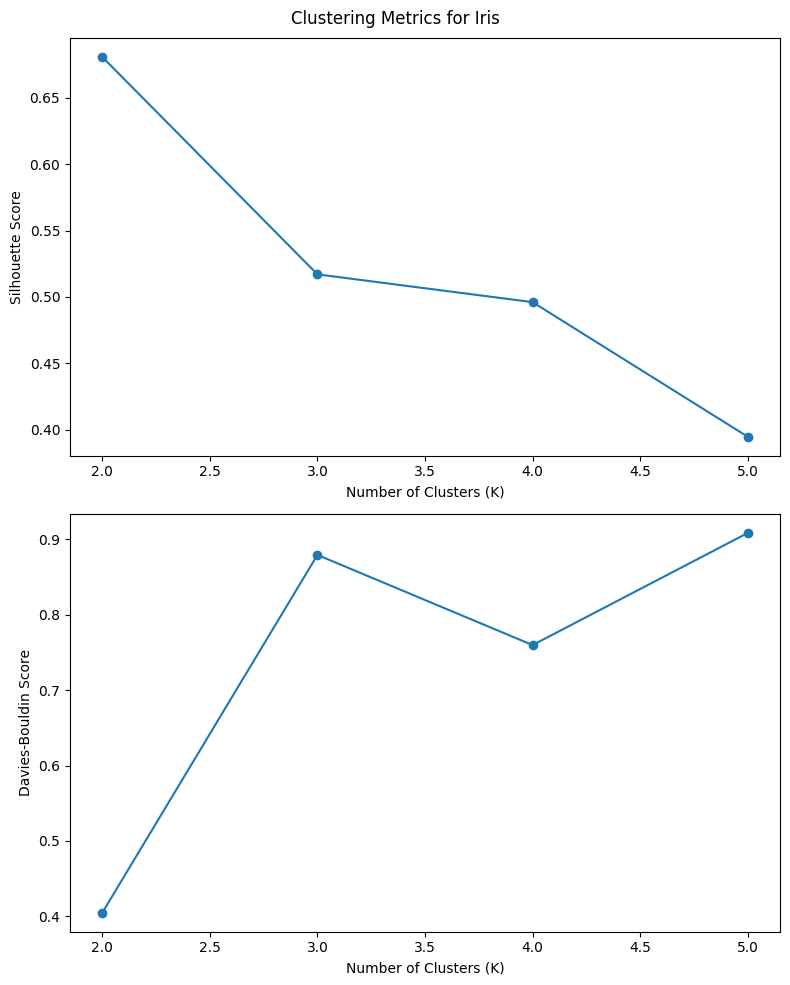

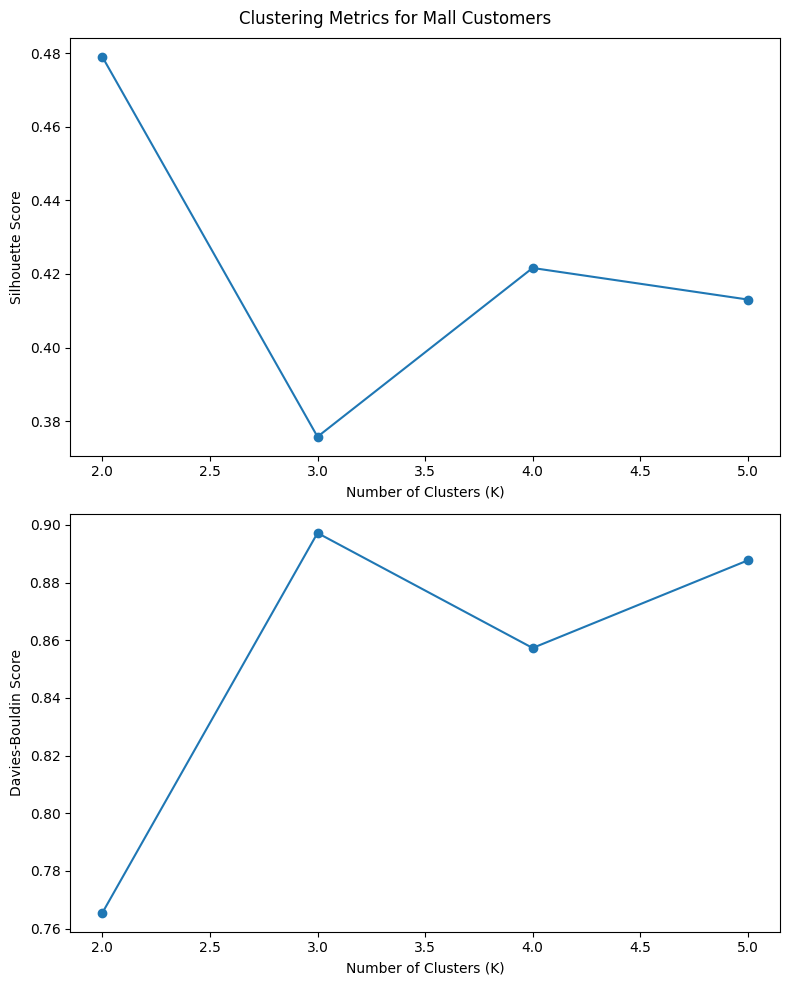

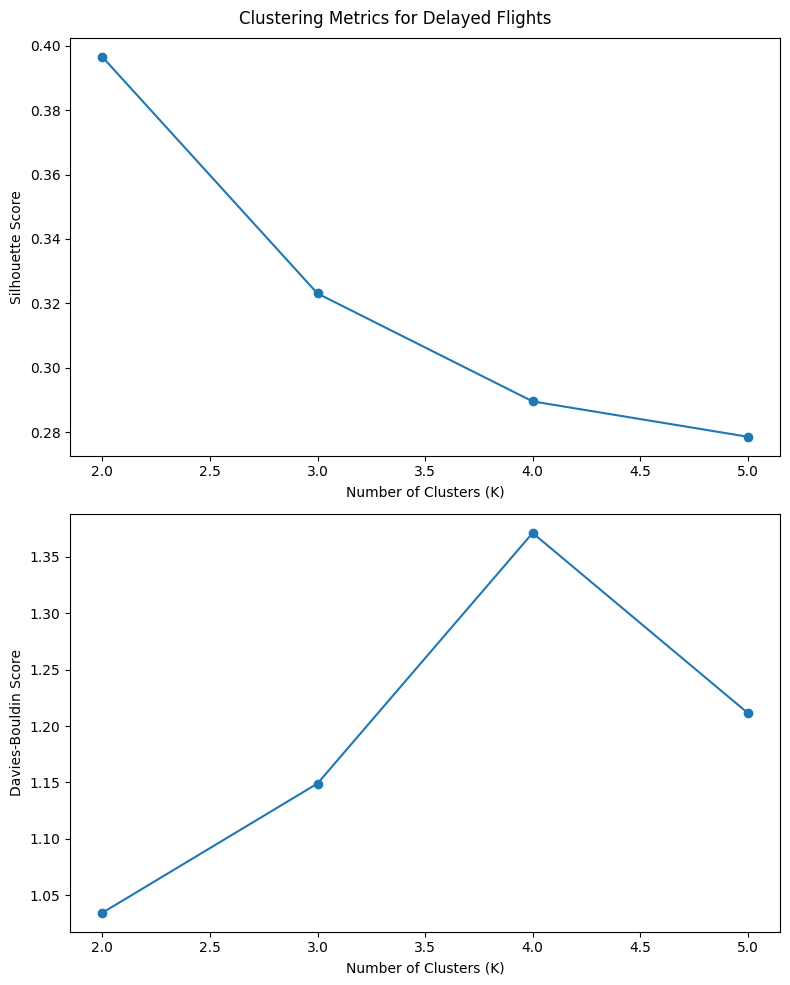

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Función para codificar columnas categóricas en datos binarios usando Bernoulli
def encode_categorical_columns(df):
    categorical_columns = df.select_dtypes(include=['object']).columns
    df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
    return df_encoded

# Función para calcular métricas de Silhouette Score y Davies-Bouldin Score
def calculate_clustering_metrics(data, clusters):
    silhouette = silhouette_score(data, clusters, metric="euclidean")
    davies_bouldin = davies_bouldin_score(data, clusters)
    return silhouette, davies_bouldin

# Cargar los conjuntos de datos
df_iris = pd.read_csv("Iris.csv")
df_mall = pd.read_csv("Mall_Customers.csv")
df_flights = pd.read_csv("delayedflights-small.csv")

# Codificar columnas categóricas en los conjuntos de datos
df_iris_encoded = encode_categorical_columns(df_iris)
df_mall_encoded = encode_categorical_columns(df_mall)
df_flights_encoded = encode_categorical_columns(df_flights)

# Aplicar kMeans y calcular métricas para cada conjunto de datos
def process_dataset(df, dataset_name):
    # Seleccionar las columnas numéricas para clustering
    numeric_columns = df.select_dtypes(include=['number']).columns

    # Aplicar K-Means a diferentes valores de K
    k_values = [2, 3, 4, 5]
    silhouette_scores = []
    davies_bouldin_scores = []

    for k in k_values:
        centroids, clusters, sse = kMeans(df[numeric_columns].values, k, eps=0.01)
        silhouette, davies_bouldin = calculate_clustering_metrics(df[numeric_columns].values, clusters)
        silhouette_scores.append(silhouette)
        davies_bouldin_scores.append(davies_bouldin)

    # Visualizar métricas
    fig, axes = plt.subplots(2, 1, figsize=(8, 10))
    fig.suptitle(f"Clustering Metrics for {dataset_name}")

    axes[0].plot(k_values, silhouette_scores, marker="o")
    axes[0].set_xlabel("Number of Clusters (K)")
    axes[0].set_ylabel("Silhouette Score")

    axes[1].plot(k_values, davies_bouldin_scores, marker="o")
    axes[1].set_xlabel("Number of Clusters (K)")
    axes[1].set_ylabel("Davies-Bouldin Score")

    plt.tight_layout()
    plt.show()

# Procesar cada conjunto de datos
process_dataset(df_iris_encoded, dataset_name="Iris")
process_dataset(df_mall_encoded, dataset_name="Mall Customers")
process_dataset(df_flights_encoded, dataset_name="Delayed Flights")
